In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import matplotlib.pyplot as plt
%matplotlib inline

import datetime as dt
import pickle
import os
import time

import seaborn as sns
sns.set()
from matplotlib import style
style.use('ggplot')

import src.utils as utils

In [2]:
df_all = pd.read_csv('data_scaled.csv')
# df_all = df_all.drop(columns=["Return"])
df_all['Date'] = pd.to_datetime(df_all['Date'])
# df_all.info()

In [3]:
# cat_vars, cont_vars = utils.cat_cont_split(df_all, omit_vars=['Date', 'Adj Close'])
cat_vars, cont_vars = utils.cat_cont_split(df_all, omit_vars=['Date'])
print(len(cat_vars), 'Categorical Features:')
print(cat_vars)
print(len(cont_vars), 'Continuous Features:')
print(cont_vars)

18 Categorical Features:
['volatility_bbhi', 'volatility_bbli', 'trend_psar_up_indicator', 'trend_psar_down_indicator', 'ticker', 'sector', 'industry', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
13 Continuous Features:
['Adj Close', 'volume_obv', 'volume_fi', 'volatility_bbm', 'volatility_bbw', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'momentum_ao', 'momentum_roc', 'Dayofyear', 'Elapsed', 'target_price']


In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
ohe = OneHotEncoder()
scaler = StandardScaler()
cont_cols = scaler.fit_transform(df_all[cont_vars])
cont_cols.shape

(621391, 13)

In [5]:
np.isnan(cont_cols).sum(), (1-np.isfinite(cont_cols)).sum()

(0, 0)

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# cat_vars = ['volatility_bbhi', 'volatility_bbli', 
#             'trend_psar_up_indicator', 'trend_psar_down_indicator', 
#             'ticker', 'exchange', 'sector', 'industry', 
#             'Year', 'Month', 'Week', 'Day', 'Dayofweek', 
#             'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
cat_features = []
for v in cat_vars:
    n = len(df_all[v].unique())
    print(v, n)
    if n > 1: #and n <= 13:
        cat_features.append(v)
print(cat_features)
ohe = OneHotEncoder()
cat_cols = ohe.fit_transform(df_all[cat_features])
cat_cols.shape

volatility_bbhi 2
volatility_bbli 2
trend_psar_up_indicator 2
trend_psar_down_indicator 2
ticker 485
sector 12
industry 104
Year 6
Month 12
Week 53
Day 31
Dayofweek 5
Is_month_end 2
Is_month_start 2
Is_quarter_end 2
Is_quarter_start 2
Is_year_end 2
Is_year_start 1
['volatility_bbhi', 'volatility_bbli', 'trend_psar_up_indicator', 'trend_psar_down_indicator', 'ticker', 'sector', 'industry', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end']


(621391, 726)

In [7]:
# X = pd.concat([cat_cols, cont_cols], axis=1)
# X.describe()
# df_ = pd.DataFrame()
# df_[cont_vars] = cont_cols
# # type(cont_cols)
len(cont_vars + ohe.get_feature_names(cat_features).tolist())

739

In [8]:
cat_tsfm = Pipeline(steps=[
    ('ohe', OneHotEncoder())
])
cont_tsfm = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median'))
#     ('scaler', StandardScaler())
])
preproc = ColumnTransformer(transformers=[
    ('cont', cont_tsfm, cont_vars),
    ('cat', cat_tsfm, cat_features)
])

tsfm_np = preproc.fit_transform(df_all)
tsfm_np.shape

# df_tsfm = pd.DataFrame(tsfm_np, columns=cont_vars + ohe.get_feature_names(cat_features).tolist())
# # tsfm_np[0]
# # for v in ['Date', 'Return', 'target_return']:
# #     df_tsfm.loc[:, v] = df[:, v]
# df_tsfm['Date'] = df_all['Date']
# df_tsfm['Return'] = df_all['Return']
# df_tsfm['target_return'] = df_all['target_return']
# df_tsfm.describe()

(621391, 739)

In [9]:
t0 = time.time()
columns=cont_vars + ohe.get_feature_names(cat_features).tolist()
df_tsfm = pd.DataFrame(data=tsfm_np.todense(), columns=columns)
df_tsfm['Date'] = df_all['Date']
print("Elapsed: %.1f sec"%(time.time()-t0))
df_tsfm.head()

Elapsed: 1.8 sec


,Adj Close,volume_obv,volume_fi,volatility_bbm,volatility_bbw,trend_macd,trend_macd_signal,trend_macd_diff,momentum_ao,momentum_roc,Dayofyear,Elapsed,target_price,volatility_bbhi_0.0,volatility_bbhi_1.0,volatility_bbli_0.0,volatility_bbli_1.0,trend_psar_up_indicator_0.0,trend_psar_up_indicator_1.0,trend_psar_down_indicator_0.0,trend_psar_down_indicator_1.0,ticker_A,ticker_AAL,ticker_AAP,ticker_AAPL,ticker_ABBV,ticker_ABC,ticker_ABMD,ticker_ABT,ticker_ACN,ticker_ADBE,ticker_ADI,ticker_ADM,ticker_ADP,ticker_ADS,ticker_ADSK,ticker_AEE,ticker_AEP,ticker_AES,ticker_AFL,ticker_AGN,ticker_AIG,ticker_AIV,ticker_AIZ,ticker_AJG,ticker_AKAM,ticker_ALB,ticker_ALGN,ticker_ALK,ticker_ALL,ticker_ALLE,ticker_ALXN,ticker_AMAT,ticker_AMD,ticker_AME,ticker_AMG,ticker_AMGN,ticker_AMP,ticker_AMT,ticker_AMZN,ticker_ANET,ticker_ANSS,ticker_ANTM,ticker_AON,ticker_AOS,ticker_APA,ticker_APD,ticker_APH,ticker_APTV,ticker_ARE,ticker_ARNC,ticker_ATO,ticker_ATVI,ticker_AVB,ticker_AVGO,ticker_AVY,ticker_AWK,ticker_AXP,ticker_AZO,ticker_BA,ticker_BAC,ticker_BAX,ticker_BBY,ticker_BDX,ticker_BEN,ticker_BIIB,ticker_BK,ticker_BKNG,ticker_BLK,ticker_BLL,ticker_BMY,ticker_BR,ticker_BSX,ticker_BWA,ticker_BXP,ticker_C,ticker_CAG,ticker_CAH,ticker_CAT,ticker_CB,ticker_CBOE,ticker_CBRE,ticker_CCI,ticker_CCL,ticker_CDNS,ticker_CDW,ticker_CE,ticker_CELG,ticker_CERN,ticker_CF,ticker_CFG,ticker_CHD,ticker_CHRW,ticker_CHTR,ticker_CI,ticker_CINF,ticker_CL,ticker_CLX,ticker_CMA,ticker_CMCSA,ticker_CME,ticker_CMG,ticker_CMI,ticker_CMS,ticker_CNC,ticker_CNP,ticker_COF,ticker_COG,ticker_COO,ticker_COP,ticker_COST,ticker_COTY,ticker_CPB,ticker_CPRT,ticker_CRM,ticker_CSCO,ticker_CSX,ticker_CTAS,ticker_CTL,ticker_CTSH,ticker_CTXS,ticker_CVS,ticker_CVX,ticker_CXO,ticker_D,ticker_DAL,ticker_DE,ticker_DFS,ticker_DG,ticker_DGX,ticker_DHI,ticker_DHR,ticker_DIS,ticker_DISCA,ticker_DISCK,ticker_DISH,ticker_DLR,ticker_DLTR,ticker_DOV,ticker_DRE,ticker_DRI,ticker_DTE,ticker_DUK,ticker_DVA,ticker_DVN,ticker_DXC,ticker_EA,ticker_EBAY,ticker_ECL,ticker_ED,ticker_EFX,ticker_EIX,ticker_EL,ticker_EMN,ticker_EMR,ticker_EOG,ticker_EQIX,ticker_EQR,ticker_ES,ticker_ESS,ticker_ETFC,ticker_ETN,ticker_ETR,ticker_EW,ticker_EXC,ticker_EXPD,ticker_EXPE,ticker_EXR,ticker_F,ticker_FANG,ticker_FAST,ticker_FB,ticker_FBHS,ticker_FCX,ticker_FDX,ticker_FE,ticker_FFIV,ticker_FIS,ticker_FISV,ticker_FITB,ticker_FLIR,ticker_FLS,ticker_FLT,ticker_FMC,ticker_FOX,ticker_FOXA,ticker_FRT,ticker_FTI,ticker_FTNT,ticker_FTV,ticker_GD,ticker_GE,ticker_GILD,ticker_GIS,ticker_GLW,ticker_GM,ticker_GOOG,ticker_GOOGL,ticker_GPC,ticker_GPN,ticker_GPS,ticker_GRMN,ticker_GS,ticker_GWW,ticker_HAL,ticker_HAS,ticker_HBAN,ticker_HBI,ticker_HCA,ticker_HD,ticker_HES,ticker_HFC,ticker_HIG,ticker_HII,ticker_HLT,ticker_HOG,ticker_HOLX,ticker_HON,ticker_HP,ticker_HPE,ticker_HPQ,ticker_HRB,ticker_HRL,ticker_HSIC,ticker_HST,ticker_HSY,ticker_HUM,ticker_IBM,ticker_ICE,ticker_IDXX,ticker_IEX,ticker_IFF,ticker_ILMN,ticker_INCY,ticker_INFO,ticker_INTC,ticker_INTU,ticker_IP,ticker_IPG,ticker_IPGP,ticker_IQV,ticker_IR,ticker_IRM,ticker_ISRG,ticker_IT,ticker_ITW,ticker_IVZ,ticker_JBHT,ticker_JCI,ticker_JEC,ticker_JKHY,ticker_JNJ,ticker_JNPR,ticker_JPM,ticker_JWN,ticker_K,ticker_KEY,ticker_KEYS,ticker_KHC,ticker_KIM,ticker_KLAC,ticker_KMB,ticker_KMI,ticker_KMX,ticker_KO,ticker_KR,ticker_KSS,ticker_KSU,ticker_L,ticker_LB,ticker_LDOS,ticker_LEG,ticker_LEN,ticker_LH,ticker_LKQ,ticker_LLY,ticker_LMT,ticker_LNC,ticker_LNT,ticker_LOW,ticker_LRCX,ticker_LUV,ticker_LW,ticker_LYB,ticker_M,ticker_MA,ticker_MAA,ticker_MAC,ticker_MAR,ticker_MAS,ticker_MCD,ticker_MCHP,ticker_MCK,ticker_MCO,ticker_MDLZ,ticker_MDT,ticker_MET,ticker_MGM,ticker_MHK,ticker_MKC,ticker_MKTX,ticker_MLM,ticker_MMC,ticker_MMM,ticker_MNST,ticker_MO,ticker_MOS,ticker_MPC,ticker_MRK,ticker_MRO,ticker_MS,ticker_MSCI,ticker_MSFT,ticker_MSI,ticker_MTB,ticker_MTD,ticker_MU,ticker_MXIM,ticker_MYL,ticker_NBL,ticker_NCLH,ticker_NDAQ,ticker_NEE,ticker_NEM,ticker_NFLX,ticker_NI,ticker_NKE,ticker_NKTR,ti

In [10]:
df_tsfm.shape

(621391, 740)

In [11]:
# df_ = df.copy()

df = df_tsfm

n_test = 126
cut_day = df['Date'].unique()[-n_test]
last_day = df['Date'].max()
print("Cut Date: ", cut_day)

train_df = df[df['Date'] < cut_day].sort_values(by='Date', ascending=False).reset_index(drop=True)
test_df = df[(df['Date'] >= cut_day) & (df['Date'] < last_day)].sort_values(by='Date', ascending=False).reset_index(drop=True)
train_df.shape, test_df.shape, train_df.Date.min(), train_df.Date.max(), test_df.Date.min(), test_df.Date.max()

Cut Date:  2019-08-16T00:00:00.000000000


((560391, 740),
 (60517, 740),
 Timestamp('2015-01-02 00:00:00'),
 Timestamp('2019-08-15 00:00:00'),
 Timestamp('2019-08-16 00:00:00'),
 Timestamp('2020-02-13 00:00:00'))

In [12]:
dep_var = "target_price"
cols = cont_vars + ohe.get_feature_names(cat_features).tolist()
cols.remove(dep_var)
Xtrain, ytrain = train_df[cols], train_df[dep_var]
Xtest, ytest = test_df[cols], test_df[dep_var]

In [13]:
import sys
sys.getsizeof(df_tsfm)/1e9

3.678634872

In [14]:
# tic = time.time()
# df.to_csv("df_tsfm_rf.csv", index=False)
# print("Elapsed: {} sec".format(time.time()-tic))
del df_tsfm, df, train_df, test_df

In [16]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0, verbose=2)
tic = time.time()
rf.fit(Xtrain, ytrain)
elapsed = time.time() - tic
print("Elapsed: {} sec".format(elapsed))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100

building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 18.7min


building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 58.6min finished


In [17]:
# import pickle
fname = "models/rf_large.mod"
pickle.dump(rf, open(fname, 'wb'))

# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
# rf = pickle.load(open(fname, 'rb'))

In [20]:
pred_test = rf.predict(Xtest)
print('\n Test metrics:')
test_scores = utils.scores(ytest, pred_test)
print(test_scores)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.3s



 Test metrics:
{'MAE': 0.016776443004876105, 'MAPE': 1.5326056662108116, 'RMSE': 0.02331025341116156, 'RMSPE': 0.02233653274128898}


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished


In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

def MAE(y, y_hat):
    return np.mean(np.abs(y_hat-y))

def MAPE(y, y_hat):
    return np.mean(np.abs(y_hat-y) / (y+5e-1)) * 100

def RMSE(y, y_hat):
    return np.sqrt(np.mean((y_hat - y)**2))

def RMSPE(y, y_hat):
    return np.sqrt(np.mean(((y - y_hat) / (y+5e-1)) ** 2))

rmpse_scorer = make_scorer(RMSPE, greater_is_better = False) # Loss function

def get_scores(y, y_hat):
    mae = MAE(y, y_hat)
    mape = MAPE(y, y_hat)
    rmse = RMSE(y, y_hat)
    rmspe = RMSPE(y, y_hat)
    print('MAE', mae)
    print('MAPE', mape)
    print('RMSE', rmse)
    print('RMSPE', rmspe)
    return mae, mape, rmse, rmspe

pred_test = rf.predict(Xtest)
mae, mape, rmse, rmspe = get_scores(ytest, pred_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.3s


MAE 0.016776443004876112
MAPE 1.5326056662108127
RMSE 0.023310253411161556
RMSPE 0.022336532741288977


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.0s finished


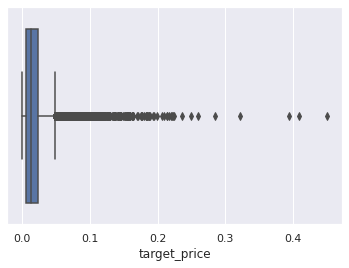

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(x=np.abs(ytest - pred_test))

In [23]:
test_preds_df = df_all[['Date', 'ticker', 'target_price']]
test_preds_df = test_preds_df[(test_preds_df['Date'] >= cut_day) \
                              & (test_preds_df['Date'] < last_day)].sort_values(by='Date', ascending=False).reset_index(drop=True)

test_preds_df['rf_pred'] = pred_test
# test_preds_df['y'] = ytest
# print(np.sum(np.abs(test_preds_df['target_price']-test_preds_df['y'])))

test_preds_df.to_csv('Results/rf_test_preds.csv', index=False)
test_preds_df.head()

,Date,ticker,target_price,rf_pred
0,2020-02-13,ZTS,0.992781,0.941340
1,2020-02-13,ADM,0.800327,0.821499
2,2020-02-13,CLX,0.963318,0.961680
3,2020-02-13,MPC,0.563533,0.579400
4,2020-02-13,ROP,1.000000,0.961907


In [24]:
# pred_train.shape, train_preds_df.shape, df_all.shape

In [25]:
tic = time.time()
pred_train = rf.predict(Xtrain)
mae, mape, rmse, rmspe = get_scores(ytrain, pred_train)
print("Elapsed: {} sec".format(time.time()-tic))

train_preds_df = df_all[['Date', 'ticker', 'target_price']]
train_preds_df = train_preds_df[train_preds_df['Date'] < cut_day].sort_values(by='Date', ascending=False).reset_index(drop=True)

train_preds_df['rf_pred'] = pred_train
# test_preds_df['y'] = ytest
# print(np.sum(np.abs(test_preds_df['target_price']-test_preds_df['y'])))
print("Elapsed: {} sec".format(time.time()-tic))

train_preds_df.to_csv('Results/rf_train_preds.csv', index=False)
print("Elapsed: {} sec".format(time.time()-tic))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   15.8s finished


MAE 0.004635017609286197
MAPE 0.5162655677931782
RMSE 0.00708548951752814
RMSPE 0.007893122248003996
Elapsed: 16.572958946228027 sec
Elapsed: 16.64620590209961 sec
Elapsed: 20.43796443939209 sec


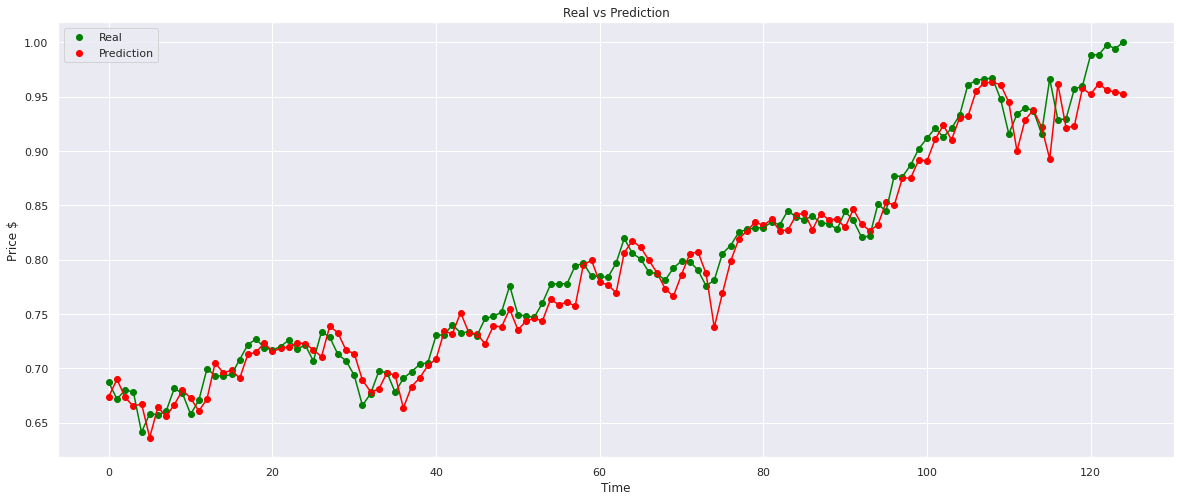

In [28]:
ticker = 'GOOG'
idx = test_preds_df[test_preds_df.ticker==ticker].index
y_plot_pred = test_preds_df.iloc[idx]['rf_pred'].values[::-1]
y_plot_real = test_preds_df.iloc[idx]['target_price'].values[::-1]

n = len(y_plot_real)
fig, ax = plt.subplots(1,1, figsize=(20,8))
x_plot = np.arange(n)
plt.plot(x_plot, y_plot_real, color="green")
plt.scatter(x_plot, y_plot_real, c="green", label="Real")
plt.plot(x_plot, y_plot_pred, color="red")
plt.scatter(x_plot, y_plot_pred, c="red", label="Prediction")
plt.title("Real vs Prediction")
plt.xlabel("Time")
plt.ylabel("Price $")
plt.legend()
plt.show()

In [23]:
n

125

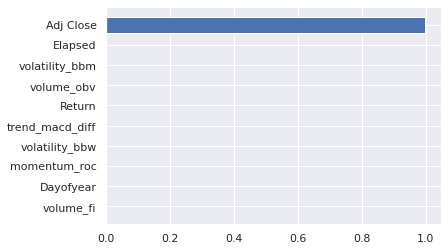

In [24]:
def plot_importance(model, cols, k=10):
    lst = list(zip(cols, model.feature_importances_))
    lst.sort(key=lambda tup: tup[1])

    labels, vals = zip(*lst)
    
    plt.barh(np.arange(k), vals[-k:], align='center')
    plt.yticks(np.arange(k), labels[-k:])
    
plot_importance(rf, cols)

# Done

In [17]:
tickers = df_all.ticker.unique().tolist()
print(len(tickers), tickers)

485 ['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AGN', 'AIG', 'AIV', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'ALXN', 'AMAT', 'AMD', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'ARNC', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BIIB', 'BK', 'BKNG', 'BLK', 'BLL', 'BMY', 'BR', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB', 'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CELG', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COO', 'COP', 'COST', 'COTY', 'CPB', 'CPRT', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 'DISH', 'DLR', 'DLTR', 'DOV', '

In [29]:
# df.columns, cat_vars

In [24]:
test_preds_all = []
from sklearn.ensemble import RandomForestRegressor
tic = time.time()
for i, ticker in enumerate(tickers):
    if i > 3:
        break
    
    print("\n##### {} {}:".format(i, ticker))
    df = df_all.loc[df_all.ticker==ticker].reset_index()
    
    cat_features = []
    for v in cat_vars:
        n = len(df[v].unique())
        if n > 1 and n <= 13:
            cat_features.append(v)
    ohe = OneHotEncoder()
    cat_cols = ohe.fit_transform(df[cat_features])
    cat_tsfm = Pipeline(steps=[
        ('ohe', OneHotEncoder())
    ])
    cont_tsfm = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median'))
    #     ('scaler', StandardScaler())
    ])
    preproc = ColumnTransformer(transformers=[
        ('cont', cont_tsfm, cont_vars),
        ('cat', cat_tsfm, cat_features)
    ])

    tsfm_np = preproc.fit_transform(df)
    df_tsfm = pd.DataFrame(tsfm_np, columns=cont_vars + ohe.get_feature_names(cat_features).tolist())
    df_tsfm['Date'] = df['Date']
    df_tsfm['Return'] = df['Return']
    df_tsfm['target_return'] = df['target_return']

    df = df_tsfm
    last_day = df['Date'].max()
    cut_day = last_day + dt.timedelta(-90)
    train_df = df[df['Date'] <= cut_day].sort_values(by='Date', ascending=False).reset_index(drop=True)
    test_df = df[(df['Date'] > cut_day) & (df['Date'] < last_day)].sort_values(by='Date', ascending=False).reset_index(drop=True)
    
    cols = cont_vars + ohe.get_feature_names(cat_features).tolist()VZ
    Xtrain, ytrain = train_df[cols + ['Return']], train_df['target_return']
    Xtest, ytest = test_df[cols + ['Return']], test_df['target_return']

    rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0)
    rf.fit(Xtrain, ytrain) 
    print('-----train:')
    yhat = rf.predict(Xtrain)
    mae, mape, rmse, rmspe = get_scores(ytrain, yhat)
    
    print('-----test:')
    yhat = rf.predict(Xtest)
    mae, mape, rmse, rmspe = get_scores(ytest, yhat)
    
    temp = pd.DataFrame([ytest, yhat], columns=['target', 'pred'])
    temp['ticker'] = ticker
    print(temp.head())
    
    elapsed = time.time() - tic
    print("Elapsed: {} sec".format(elapsed))


##### 0 A:
-----train:
MAE 0.4794532102733153
MAPE -8.94281158395727
RMSE 0.6745706358887346
RMSPE 3.266022585066239
-----test:
MAE 1.2987815625055465
MAPE 89.72693375023354
RMSE 1.6030935865701486
RMSPE 8.15729068346349
               target  pred ticker
target_return     NaN   NaN      A
Unnamed 0         NaN   NaN      A
Elapsed: 0.806563138961792 sec

##### 1 AAL:
-----train:
MAE 0.7913867538903252
MAPE 24.30306977457901
RMSE 1.102906375267511
RMSPE 4.337749238319022
-----test:
MAE 1.8454492975355923
MAPE 18.938936873202152
RMSE 2.37983104263355
RMSPE 1.3146136811401905
               target  pred ticker
target_return     NaN   NaN    AAL
Unnamed 0         NaN   NaN    AAL
Elapsed: 1.517080545425415 sec

##### 2 AAP:
-----train:
MAE 0.4710475072215458
MAPE -7.137395597232324
RMSE 0.724348931026707
RMSPE 2.8972312219465195
-----test:
MAE 1.4330820445476953
MAPE 165.59407689600278
RMSE 1.830131583142191
RMSPE 13.472333029065066
               target  pred ticker
target_return     Na

In [107]:
tic = time.time()
for i, ticker in enumerate(tickers):
    print("\n##### {} {}:".format(i, ticker))
    df = df_all.loc[df_all.ticker==ticker].reset_index()
    
    cat_features = []
    for v in cat_vars:
        n = len(df[v].unique())
        if n > 1 and n <= 13:
            cat_features.append(v)
    ohe = OneHotEncoder()
    cat_cols = ohe.fit_transform(df[cat_features])
    cat_tsfm = Pipeline(steps=[
        ('ohe', OneHotEncoder())
    ])
    cont_tsfm = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median'))
    #     ('scaler', StandardScaler())
    ])
    preproc = ColumnTransformer(transformers=[
        ('cont', cont_tsfm, cont_vars),
        ('cat', cat_tsfm, cat_features)
    ])

    tsfm_np = preproc.fit_transform(df)
    df_tsfm = pd.DataFrame(tsfm_np, columns=cont_vars + ohe.get_feature_names(cat_features).tolist())
    df_tsfm['Date'] = df['Date']
    df_tsfm['Return'] = df['Return']
    df_tsfm['target_return'] = df['target_return']

    df = df_tsfm
    last_day = df['Date'].max()
    cut_day = last_day + dt.timedelta(-90)
    train_df = df[df['Date'] <= cut_day].sort_values(by='Date', ascending=False).reset_index(drop=True)
    test_df = df[(df['Date'] > cut_day) & (df['Date'] < last_day)].sort_values(by='Date', ascending=False).reset_index(drop=True)
    
    cols = cont_vars + ohe.get_feature_names(cat_features).tolist()
    Xtrain, ytrain = train_df[cols + ['Return']], train_df['target_return']
    Xtest, ytest = test_df[cols + ['Return']], test_df['target_return']

    rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0)
    rf.fit(Xtrain, ytrain)
    elapsed = time.time() - tic
    
    yhat = rf.predict(Xtrain)
    mae, mape, rmse, rmspe = get_scores(ytrain, y_hat)
    
    yhat = rf.predict(Xtest)
    mae, mape, rmse, rmspe = get_scores(ytest, y_hat)
    print("Elapsed: {} sec".format(elapsed))

1.9956817260198843

In [84]:
for i in range(len(ytest)):
    print(i, ytest[i], yhat[i])

0 -0.3606882701431169 0.3619726960434633
1 -0.4380870753657007 1.0750094148218867
2 3.4263720142657883 1.4758979328505661
3 9.227908773513073 0.8241386144147611
4 -0.7732928024750119 0.9710192546476225
5 0.17604017399455166 0.1298597565746662
6 -0.3545297116761659 0.5775738974968947
7 1.2459862690825665 0.6679205872750128
8 1.2638301271357344 0.5287516896273227
9 -1.7644767543437467 0.10526578280352972
10 0.18809564869946005 -0.3431808631647549
11 1.2942720369481189 0.4487531603673645
12 -1.1842042081131376 0.8516513971719132
13 0.2036482673230422 0.5922764039542538
14 1.4170880558339594 -0.15186673100736067
15 -0.4561091163650888 0.18921855206442295
16 0.6111731104259555 -0.11492229000879424
17 -1.8732221236568147 -0.07112075102205236
18 -0.5954575889268843 0.5772199201430817
19 -0.4670044763790404 0.6439486907615377
20 0.5563649142592331 0.3352657626798895
21 -0.9051770165475092 0.09422752097626219
22 -1.2217814757187195 0.7674738691264582
23 -1.4873487559496468 0.4364595244874758
24

1162 0.3657756625191855 0.7195480586331037
1163 1.8918905172262024 -1.4520429516628166
1164 0.5530030483425374 0.22935749277206213
1165 0.7147047369949089 0.08663537539879354
1166 0.4926103745908517 0.5519847597828436
1167 -0.5850522140657177 -0.7032397327743235
1168 1.2769899405190133 0.5765398831110513
1169 0.21129956436276576 0.3643509730231575
1170 -1.0348003157544359 -0.1342402523406095
1171 -2.683131060685684 0.32011321658750524
1172 0.2410551963278218 -0.1006005734229484
1173 -7.5565925052629925 0.12388833580003426
1174 2.143019246227196 0.9822900309409753
1175 0.13670046231273325 0.7565089789458679
1176 0.09313338077452382 -0.12485280072565108
1177 -6.171699612120907 0.37304681037292453
1178 0.5071356298299579 1.241549013513351
1179 2.236522142931152 0.42815856353767173
1180 -1.9644433980600342 0.8825200748403251
1181 -0.2678901533579636 0.6102860591276016
1182 -0.7536303111343123 0.8030006309862102
1183 -2.3839385130147277 1.2585875373737199
1184 -1.1565846716025896 0.80506163

2385 -0.16708819814117426 -2.288819209147306
2386 3.5252397464554 0.43006888847650915
2387 1.5720112330068983 0.3957859680209175
2388 -0.15408898729443174 0.6411887386366666
2389 0.2943515081902825 0.5758273572457573
2390 -1.9591019603895419 -0.09874802853542364
2391 -0.7139419662186008 0.07908757718321675
2392 0.04101396086129139 0.23118996197966535
2393 -0.4563902419963184 0.37315322957221847
2394 0.9995435862028224 0.5428769467487736
2395 1.4471417269216411 0.8743954767838215
2396 -1.1182647277077296 1.8725396298489236
2397 3.986249262186004 -0.4622440053865473
2398 0.2897581478666478 0.4549786436377879
2399 -0.27426899789385617 0.395112471075928
2400 2.5152594874407126 1.141528091007663
2401 2.431657380517893 0.46727776191656467
2402 0.18625290394789215 -0.16914050248630902
2403 1.3800596546767574 0.7612255277614398
2404 0.24168599584248884 0.23974247068437204
2405 1.3893055753337882 0.9384819237957529
2406 1.2010788493696856 1.3210720864721113
2407 -0.6033284139495332 0.7086937007

3596 0.11034000053518067 0.3366221920469526
3597 0.6598101312676352 0.05610983793614577
3598 -0.2894330307154025 0.4848695612467869
3599 -0.5555564712921734 0.7831105155018471
3600 -1.5314734048525902 -0.5648760324881964
3601 -0.19687721620980086 1.0109591679459762
3602 1.19818525072668 0.3832877841179081
3603 1.1425537950279228 0.05712518892904683
3604 3.3610760078682134 1.8126628068110917
3605 0.5826957325635318 1.5938104093220613
3606 0.2378983992791017 -1.3911884335722724
3607 -1.3016089108986328 0.23151710427990793
3608 0.451827415053474 -0.40086337238925085
3609 -0.9608945367056588 0.06537079623308735
3610 -0.523858914868891 0.5720631898195228
3611 2.17939496919497 0.4933661293755531
3612 0.25443567118539345 0.5669063998874446
3613 2.1486460847687683 -0.06718610858954532
3614 -0.07820934900967247 0.619583865456993
3615 -0.9998712207221594 0.713558272893251
3616 0.03636414340071337 0.7686015137826685
3617 0.9116610628233212 0.4281253058073931
3618 -0.4473636024876604 -0.4446709215

4731 1.1292755812125188 -0.30835641567968686
4732 2.024014272071684 -0.20522682490812905
4733 -0.02284642253610469 0.6613334263476289
4734 1.4440079968646602 0.37780421238291284
4735 2.8650941223949955 -0.10284314968351467
4736 0.18672399926664696 0.605945539783137
4737 -0.2539710744679513 0.6851722378574011
4738 -1.95866801889375 0.37557964112533426
4739 1.5079331319920009 0.724706666220818
4740 1.0190000492727336 0.5615943908006127
4741 1.6438950795373275 -0.057426154381202646
4742 -0.42970961543371533 0.7238880375191836
4743 3.5762658132403087 0.7905192088273684
4744 1.7590125158793324 0.46477268439885755
4745 2.99694042621248 1.2140287286845677
4746 2.5030346077851817 0.35217685660344666
4747 3.372589862190312 -0.03104294363983846
4748 2.2762250520087512 -0.2702444667762606
4749 1.3156430739832636 0.19775994236565952
4750 1.6676750964586873 0.8318731014126601
4751 -0.8303499291736238 0.5623494228816738
4752 -0.492614490181531 1.1031462474636557
4753 1.419388829987378 0.275547484478

5936 -1.6526381780907484 -0.623338601026795
5937 -1.014765763866721 0.0200796393034663
5938 0.5704008990838005 0.6530861045876823
5939 3.080087173363455 0.6183237108002271
5940 2.318122383947041 -0.2010881244358309
5941 -2.740193530631818 0.07426225622818468
5942 0.5328086262742726 2.219717955107038
5943 1.6183451485929146 0.7923858264369532
5944 -0.7172310984479568 0.8732135377973116
5945 1.3346504614142995 1.2087278537883095
5946 -0.7080525414407846 0.8051088242564621
5947 0.9827876901626452 0.450698816620021
5948 2.6985807250946348 0.7370751240743545
5949 -0.3881022508588239 0.9897579789373813
5950 0.5229031433152453 0.8555055743141484
5951 0.3943074490251108 -0.2739862015327111
5952 -5.069563151377522 0.14500198499457606
5953 1.2017727053942548 0.5955179526858122
5954 0.5313482853793516 -0.27388675314574795
5955 -2.2221260075668936 0.8146366257636959
5956 -0.2425092117461114 0.16526320362070135
5957 -0.9210764170415886 0.7332507655504517
5958 0.661262522867534 0.3853432108543764
59

7128 0.5691649173590774 0.521727782532424
7129 0.5160201745892268 0.9502633598406153
7130 1.4512997626108026 -0.4354278543556355
7131 -1.8552028974437642 -0.6133322314011946
7132 1.8938047696003932 -0.9164132495160281
7133 -1.1553657756195657 0.9005663550047871
7134 1.440226779449616 0.3278144153797246
7135 0.9891722671948378 0.17952048788675948
7136 0.8959324617163089 1.9013809573843132
7137 1.4328413143383625 0.43992397684910706
7138 0.3022439347383665 0.8804864345354557
7139 3.545664790154457 0.44232498797610376
7140 1.5880878455696967 0.7506087850700538
7141 3.025656797056953 -0.5247992564520885
7142 0.5854823297213763 0.6149275976069191
7143 0.8154233670712996 0.40459523562151656
7144 1.301348341026265 1.692689260349076
7145 -1.336903463767103 0.46621350102658654
7146 5.733636476910875 -0.6519697486145016
7147 2.8657666359035883 -0.32225724502890524
7148 2.3999972873263835 -1.5828091045480843
7149 1.6597944436613998 0.9759754081823202
7150 2.648424194213006 0.9315810393327595
7151

8349 0.05525728613426928 0.6843154742489933
8350 -0.7876952502093859 0.04556432653282205
8351 0.9364338368695212 -0.4420959222787791
8352 2.2621207598969573 0.2942722367020801
8353 2.734245140346592 -0.010033950767274202
8354 -0.03991709000378263 0.15849155809237175
8355 0.7149524788498063 0.004004009883836712
8356 -0.506728438472992 0.5871975103610261
8357 0.2434549191638657 0.27889419993113
8358 -1.418369678143527 0.46067740040326316
8359 -1.4626008232604517 0.7759772224936357
8360 -1.4598494877876678 0.898314138445445
8361 -2.147546729933958 -0.6410201968756668
8362 0.7388794469318727 0.6115038124065628
8363 -0.9970211300178056 -0.3576419472056581
8364 -0.7072474359083314 0.3167958232686452
8365 -0.6641678840955789 0.6157946590021623
8366 -1.2961811988581928 1.4849158089792591
8367 -0.30825671502574536 -0.7631497390171038
8368 -0.6451596495925749 -0.005564178579653456
8369 -0.6837798260832639 -0.3943122903687312
8370 0.35301864855654674 0.7742010432036617
8371 1.027280809957598 0.11

In [15]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [16]:
X, y = fetch_openml('titanic', version=1, as_frame=True, return_X_y=True)

In [20]:
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']
X = X[categorical_columns + numerical_columns]

In [22]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, random_state=42)

In [23]:
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preproc = ColumnTransformer([
    ('cat', cat_pipe, categorical_columns),
    ('num', num_pipe, numerical_columns)
])

rf = Pipeline([
    ('preproc', preproc),
    ('learner', RandomForestClassifier(random_state=42))
])

In [24]:
rf.fit(Xtrain, ytrain)

Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                           

In [26]:
print("RF train accuracy: %0.3f" % rf.score(Xtrain, ytrain))
print("RF test accuracy: %0.3f" % rf.score(Xtest, ytest))

RF train accuracy: 1.000
RF test accuracy: 0.817


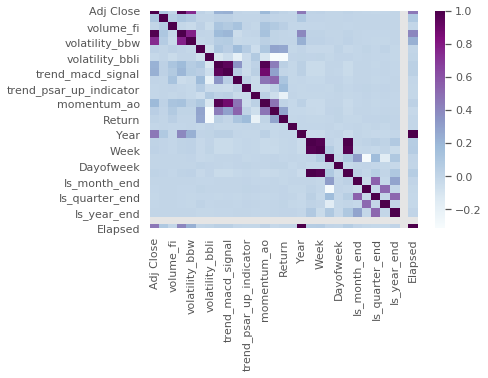

In [30]:
# plt.subplot(figsize=(11, 9))
corr = df.corr()
sns.heatmap(corr, cmap='BuPu')
plt.show()

# Evaluation Metrics

In [2]:
targets = pd.read_csv('./Results/test_targets.csv')
targets.head()

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,ALXN,AMAT,AMD,AME,AMG,AMGN,AMP,AMT,AMZN,ANET,ANSS,ANTM,AON,AOS,APA,APD,APH,APTV,ARE,ARNC,ATO,ATVI,AVB,AVGO,AVY,AWK,AXP,AZO,BA,BAC,BAX,BBY,BDX,BEN,BIIB,BK,BKNG,BLK,BLL,BMY,BR,BSX,BWA,BXP,C,CAG,CAH,CAT,CB,CBOE,CBRE,CCI,CCL,CDNS,CDW,CE,CELG,CERN,CF,CFG,CHD,CHRW,CHTR,CI,CINF,CL,CLX,CMA,CMCSA,CME,CMG,CMI,CMS,CNC,CNP,COF,COG,COO,COP,COST,COTY,CPB,CPRT,CRM,CSCO,CSX,CTAS,CTL,CTSH,CTXS,CVS,CVX,CXO,D,DAL,DE,DFS,DG,DGX,DHI,DHR,DIS,DISCA,DISCK,DISH,DLR,DLTR,DOV,DRE,DRI,DTE,DUK,DVA,DVN,DXC,EA,EBAY,ECL,ED,EFX,EIX,EL,EMN,EMR,EOG,EQIX,EQR,ES,ESS,ETFC,ETN,ETR,EW,EXC,EXPD,EXPE,EXR,F,FANG,FAST,FB,FBHS,FCX,FDX,FE,FFIV,FIS,FISV,FITB,FLIR,FLS,FLT,FMC,FOX,FOXA,FRT,FTI,FTNT,FTV,GD,GE,GILD,GIS,GLW,GM,GOOG,GOOGL,GPC,GPN,GPS,GRMN,GS,GWW,HAL,HAS,HBAN,HBI,HCA,HD,HES,HFC,HIG,HII,HLT,HOG,HOLX,HON,HP,HPE,HPQ,HRB,HRL,HSIC,HST,HSY,HUM,IBM,ICE,IDXX,IEX,IFF,ILMN,INCY,INFO,INTC,INTU,IP,IPG,IPGP,IQV,IR,IRM,ISRG,IT,ITW,IVZ,JBHT,JCI,JEC,JKHY,JNJ,JNPR,JPM,JWN,K,KEY,KEYS,KHC,KIM,KLAC,KMB,KMI,KMX,KO,KR,KSS,KSU,L,LB,LDOS,LEG,LEN,LH,LKQ,LLY,LMT,LNC,LNT,LOW,LRCX,LUV,LW,LYB,M,MA,MAA,MAC,MAR,MAS,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,MGM,MHK,MKC,MKTX,MLM,MMC,MMM,MNST,MO,MOS,MPC,MRK,MRO,MS,MSCI,MSFT,MSI,MTB,MTD,MU,MXIM,MYL,NBL,NCLH,NDAQ,NEE,NEM,NFLX,NI,NKE,NKTR,NLSN,NOC,NOV,NRG,NSC,NTAP,NTRS,NUE,NVDA,NVR,NWL,NWS,NWSA,O,OKE,OMC,ORCL,ORLY,OXY,PAYX,PBCT,PCAR,PEG,PEP,PFE,PFG,PG,PGR,PH,PHM,PKG,PKI,PLD,PM,PNC,PNR,PNW,PPG,PPL,PRGO,PRU,PSA,PSX,PVH,PWR,PXD,PYPL,QCOM,QRVO,RCL,RE,REG,REGN,RF,RHI,RJF,RL,RMD,ROK,ROL,ROP,ROST,RSG,RTN,SBAC,SBUX,SCHW,SEE,SHW,SIVB,SJM,SLB,SLG,SNA,SNPS,SO,SPG,SPGI,SRE,STT,STX,STZ,SWK,SWKS,SYF,SYK,SYY,T,TAP,TDG,TEL,TFX,TGT,TIF,TJX,TMO,TMUS,TPR,TRIP,TROW,TRV,TSCO,TSN,TTWO,TWTR,TXN,TXT,UA,UAA,UAL,UDR,UHS,ULTA,UNH,UNM,UNP,UPS,URI,USB,UTX,V,VAR,VFC,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WLTW,WM,WMB,WMT,WRK,WU,WY,WYNN,XEC,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
0,2020-02-14,-1.200185,-1.952060,6.153156,-1.831055,-0.467839,-0.052992,1.064465,-0.869960,0.654518,-0.215979,0.781979,-0.714764,-0.728280,-2.265877,-0.904522,-0.046089,0.549344,0.477785,-1.761031,-0.161359,1.093232,0.127737,-0.505193,-0.595458,1.294272,-1.048642,-1.825794,-0.937835,-1.011385,-3.268534,-0.390010,-2.528040,2.856623,-0.858491,0.446315,-0.800964,-0.855617,-1.295613,0.974289,1.038167,-0.369894,1.554632,-0.195135,0.113816,2.741228,-0.105466,-2.575190,-0.339677,-0.617382,-0.539569,0.099629,0.346350,0.237335,-2.209142,-1.556511,-0.043076,-0.198711,1.959725,-0.472844,-1.664270,-0.987758,-0.055421,-1.621705,6.937597,1.231233,-1.328977,-0.737329,-0.199669,1.061901,-0.467004,0.188096,-0.354530,0.556365,0.190178,-1.535727,-6.148664,-1.023148,-1.021816,-0.644140,-1.663612,-0.781739,0.144608,0.751173,-0.228543,-2.473063,-2.063258,NaN,-0.376282,-0.365534,-1.836046,-0.366347,0.611019,0.506639,0.730689,-1.180454,-0.808453,-0.006064,-1.274696,0.130183,0.112603,0.609584,-0.431707,0.510872,2.725588,-0.367919,0.379968,3.378378,0.860437,-0.545888,1.174952,1.139352,-0.904602,-0.803876,0.600158,-0.809029,-0.100508,0.541746,-4.028773,0.599245,1.212819,0.882720,0.145345,-1.655333,1.737942,-0.305603,-1.053135,-1.400157,2.328677,-0.230396,0.032358,-1.175051,-0.286652,0.297915,0.487300,3.302476,1.292773,2.706362,0.050056,0.103952,-1.002384,0.470071,0.730646,-0.674578,-2.892199,-3.374429,-0.209685,-0.707919,0.178474,0.053017,-2.043447,-0.025923,-1.660384,-2.716454,-2.815943,-0.520554,-0.780853,-0.219758,1.227839,-0.077120,-0.905177,0.888458,0.484600,-0.438087,1.245986,1.417088,-1.384369,-0.025989,-0.493827,-0.546890,-0.078285,1.690172,-0.520616,-1.797380,-0.031514,0.076586,0.149004,-1.136946,-0.057227,-1.216218,-1.617104,-0.926525,0.672052,0.303404,-0.241223,-0.052911,-0.275097,-0.753193,0.218134,-0.205624,0.042541,-0.623538,-0.814084,0.431438,-2.168593,-1.006900,-0.070357,0.046747,0.300613,0.339203,-4.079381,-1.079647,-1.632358,0.172273,-1.175408,-0.296798,-1.207387,1.

In [3]:
rf_preds = pd.read_csv('./Results/rf_preds.csv')
rf_preds.head()

,target,pred,ticker
0,-1.200185,-1.266855,A
1,0.409499,-1.182547,A
2,0.046823,-1.034663,A
3,0.399582,-1.727513,A
4,0.781708,-2.533976,A


In [5]:
diff = rf_preds['pred'] - rf_preds['target']

0   -0.066670
1   -1.592045
2   -1.081486
3   -2.127094
4   -3.315684
dtype: float64